In [1]:
from ott.neural.flows.models import VelocityField
from ott.neural.flows.flows import ConstantNoiseFlow
from ott.neural.flows.samplers import sample_uniformly
from ott.neural.flows.otfm import OTFlowMatching
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.neural.data.dataloaders import OTDataLoader

import optax
import scanpy as sc
import anndata as ad

import jax.numpy as jnp

import numpy as np
import pandas as pd

In [2]:
adata = sc.read_h5ad('500k_example.h5ad')
adata.obs.day.unique()

['E13.0', 'E17.0', 'E14.0', 'E12.75', 'E9.75', ..., 'E13.5', 'E17.25', 'E17.5', 'E17.75', 'E9.0']
Length: 43
Categories (43, object): ['E8.5', 'E8.75', 'E9.0', 'E9.5', ..., 'E18.5', 'E18.25', 'E18.75', 'P0']

In [3]:
adata.obs.day = [float(x[1:]) for x in adata.obs.day]

In [4]:
#adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/100k/2k_genes/integrated_adata.h5ad')

adata_loader = OTDataLoader(1024, source_lin=adata[adata.obs['day']==10.25].obsm['X_emb'], target_lin=adata[adata.obs['day']==10.5].obsm['X_emb'])

neural_vf = VelocityField(
    output_dim=50,
    condition_dim=0,
    latent_embed_dim=256,
    n_frequencies=128
)
ot_solver = sinkhorn.Sinkhorn()
time_sampler = sample_uniformly
optimizer = optax.adam(learning_rate=1e-4)
fm = OTFlowMatching(
    neural_vf,
    input_dim=50,
    cond_dim=0,
    iterations=1000,
    valid_freq=2,
    ot_solver=ot_solver,
    flow=ConstantNoiseFlow(0.0),
    time_sampler=time_sampler,
    optimizer=optimizer
)
fm(adata_loader, adata_loader)

In [5]:
result_forward = fm.transport(jnp.array(adata[adata.obs['day']==10.25].obsm['X_emb']), condition=None, forward=True)
tmp = adata[adata.obs.day==10.25]
tmp.obsm['X_new'] = result_forward
tmp

/tmp/ipykernel_2672946/1569231491.py:3: ImplicitModificationWarning: Setting element `.obsm['X_new']` of view, initializing view as actual.
  tmp.obsm['X_new'] = result_forward


AnnData object with n_obs × n_vars = 14254 × 24552
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'batch', 'cell_cluster', 'celltype', 'cellcluster_moscot', '_scvi_batch', '_scvi_labels'
    obsm: 'X_emb', 'X_new'

In [6]:
sc.pp.neighbors(tmp, use_rep='X_new')
sc.tl.umap(tmp)
sc.pl.umap(tmp, color='cellcluster_moscot')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of type(CPUDispatcher(<function angular_random_projection_split at 0x7fd1c83e0540>)) with parameters (readonly array(float32, 2d, C), array(int32, 1d, C), array(int64, 1d, C))
Known signatures:
 * (Array(float32, 2, 'C', False, aligned=True), Array(int32, 1, 'C', False, aligned=True), Array(int64, 1, 'C', False, aligned=True)) -> Tuple(array(int32, 1d, C), array(int32, 1d, C), array(float32, 1d, C), float64)
During: resolving callee type: type(CPUDispatcher(<function angular_random_projection_split at 0x7fd1c83e0540>))
During: typing of call at /home/icb/jonas.flor/mambaforge/envs/moscot_flow/lib/python3.11/site-packages/pynndescent/rp_trees.py (639)


File "../../../../../mambaforge/envs/moscot_flow/lib/python3.11/site-packages/pynndescent/rp_trees.py", line 639:
def make_angular_tree(
    <source elided>
            offset,
        ) = angular_random_projection_split(data, indices, rng_state)
        ^

During: resolving callee type: type(CPUDispatcher(<function make_angular_tree at 0x7fd1bf5160c0>))
During: typing of call at /home/icb/jonas.flor/mambaforge/envs/moscot_flow/lib/python3.11/site-packages/pynndescent/rp_trees.py (834)

During: resolving callee type: type(CPUDispatcher(<function make_angular_tree at 0x7fd1bf5160c0>))
During: typing of call at /home/icb/jonas.flor/mambaforge/envs/moscot_flow/lib/python3.11/site-packages/pynndescent/rp_trees.py (834)


File "../../../../../mambaforge/envs/moscot_flow/lib/python3.11/site-packages/pynndescent/rp_trees.py", line 834:
def make_dense_tree(data, rng_state, leaf_size=30, angular=False, max_depth=200):
    <source elided>
    if angular:
        make_angular_tree(
        ^


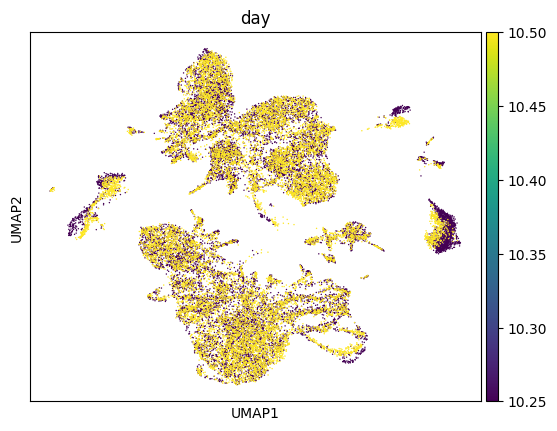

In [7]:
adata_concat = sc.concat(
    [adata[adata.obs.day==10.25], adata[adata.obs.day==10.5]],
)  
adata_concat.obsm["X_new"] = np.concatenate(
    (np.array(result_forward), adata[adata.obs.day==10.5].obsm['X_emb']),
    axis=0
)
#del adata_concat.obsm['X_diffmap']

sc.pp.neighbors(adata_concat, use_rep='X_new')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color='day')

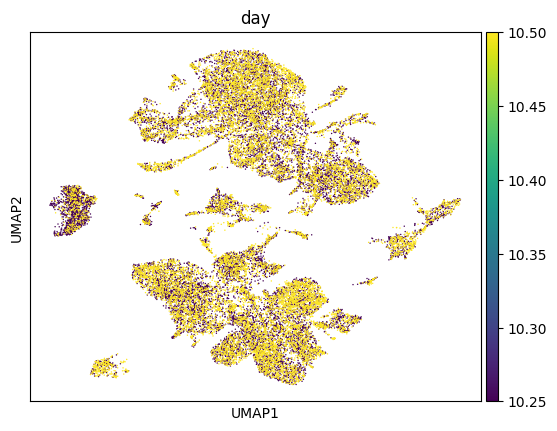

In [8]:
#adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/100k/2k_genes/integrated_adata.h5ad')
adata = adata[[x in [10.5, 10.25] for x in adata.obs.day]]
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color='day')

In [11]:
adata.obs.day.unique()

array([10.25, 10.5 ])

In [22]:
adata_out = adata[:, :50]
#sc.pp.pca(adata_out)
adata_out.layers['velocity'] = np.array(fm.transport(jnp.array(adata.obsm['X_emb'])))-adata.obsm['X_emb']
adata_out.layers['X_emb'] = adata.obsm['X_emb']
adata_out

/tmp/ipykernel_2672946/3693377496.py:3: ImplicitModificationWarning: Setting element `.layers['velocity']` of view, initializing view as actual.
  adata_out.layers['velocity'] = np.array(fm.transport(jnp.array(adata.obsm['X_emb'])))-adata.obsm['X_emb']


AnnData object with n_obs × n_vars = 28570 × 50
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'batch', 'cell_cluster', 'celltype', 'cellcluster_moscot', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_emb', 'X_umap'
    layers: 'velocity', 'X_emb'
    obsp: 'distances', 'connectivities'

In [23]:
adata_out.write('500k_otfm.h5ad')